In [1]:
%%capture
# IMPORTS
import io
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import scipy.io as sio
import GDI
import seaborn as sns
from IPython.utils import io as uio

In [2]:
# FONT SIZE
plt.rcParams.update({'font.size': 14});

In [3]:
# PARAMETERS
M           = 3
bin_width   = 50
boot_iter   = 5

In [4]:
# LOAD CPG SPIKES (BINNED AT 0.2 ms RESOLUTION)
binned_spikes = sio.loadmat('cpg.mat')['spike_times_binned']
time = sio.loadmat('cpg.mat')['time'][0,:]
time_max = np.max(time)
neuron_names = ["CBI2","B4","B8","B20","B30","B31a","B34","B40",
                "B51a","B52","B63","B64a","B65"]

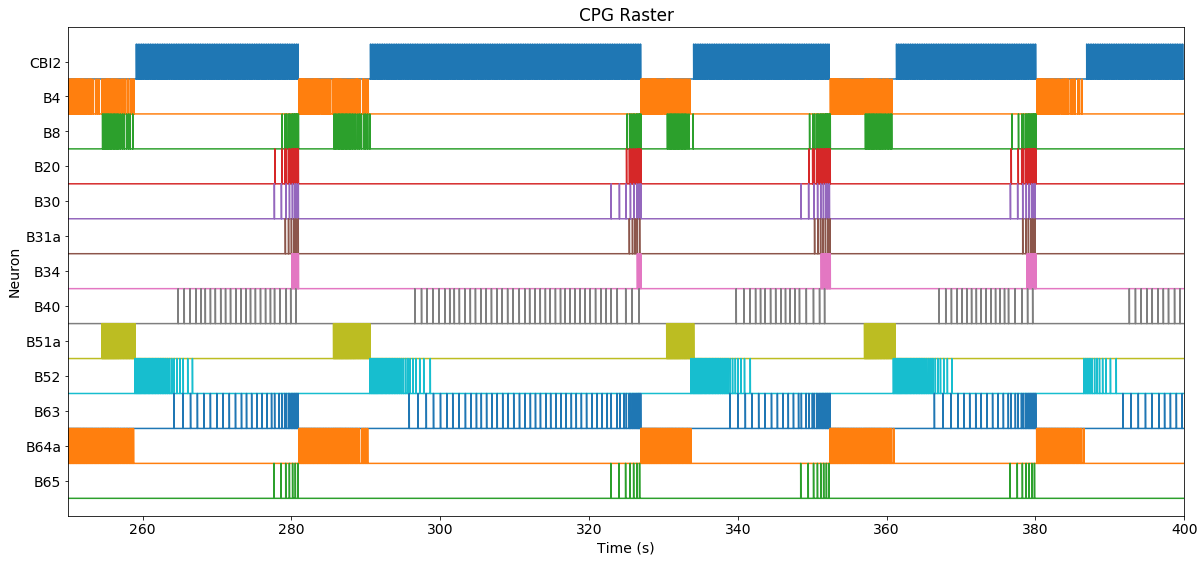

In [5]:
# PLOT binned_spikes
f, ax = plt.subplots(figsize=(20, 9));
for ii in range(binned_spikes.shape[1]):
    plt.plot(time, ii+1.5-binned_spikes[:,ii], label='Neuron = %i'%(ii+1));

plt.xlim((250,400));
plt.xlabel('Time (s)');
plt.ylabel('Neuron');
plt.gca().invert_yaxis();
plt.yticks(np.arange(binned_spikes.shape[1])+1,neuron_names);
plt.ylim((14,0))
plt.title('CPG Raster');

In [6]:
# FURTHER BIN SPIKE TIMES
num_bins = np.ceil(time_max/(bin_width*0.001))
range_max = num_bins*(bin_width*0.001)
further_binned_spikes = np.zeros((int(num_bins),binned_spikes.shape[1]))
for ii in range(binned_spikes.shape[1]):
    further_binned_spikes[:,ii], time_further_binned = np.histogram(time[binned_spikes[:,ii].astype(bool)],
                     bins=np.arange(0,range_max+((bin_width*0.001)/2),(bin_width*0.001)))

# CAP BINS TO 1 SPIKE
further_binned_spikes[further_binned_spikes>0]=1

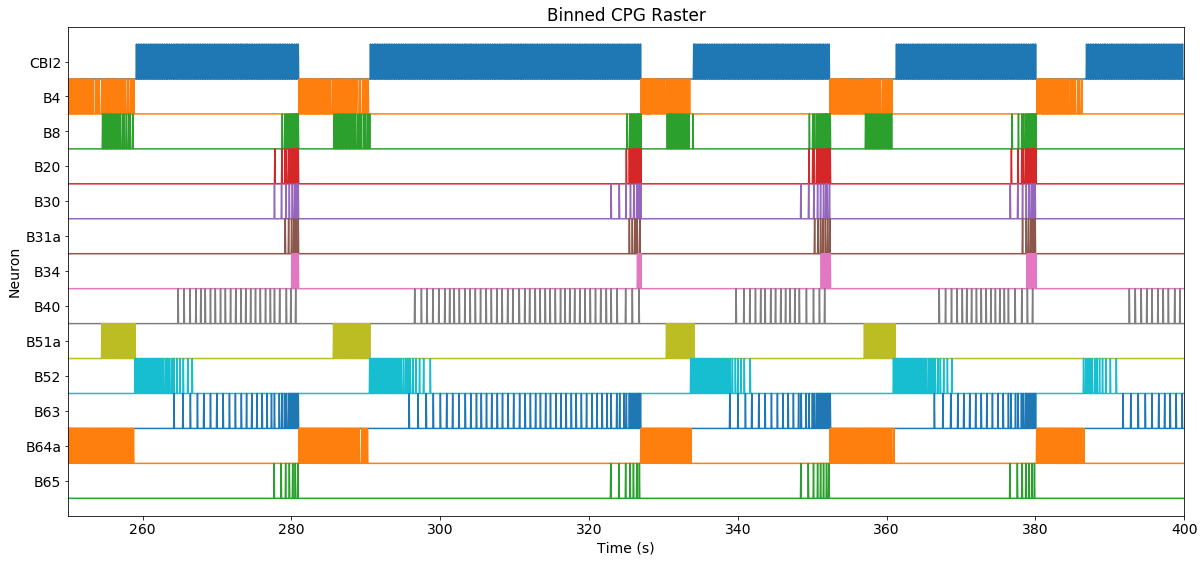

In [7]:
# PLOT further_binned_spikes
f, ax = plt.subplots(figsize=(20, 9))
for ii in range(further_binned_spikes.shape[1]):
    plt.plot(time_further_binned[:-1]+((bin_width*0.001)/2), ii+1.5-further_binned_spikes[:,ii])

plt.xlim((250,400));
plt.xlabel('Time (s)');
plt.ylabel('Neuron');
plt.gca().invert_yaxis();
plt.yticks(np.arange(binned_spikes.shape[1])+1,neuron_names);
plt.ylim((14,0))
plt.title('Binned CPG Raster');

In [8]:
%%capture
# LOAD NORMALIZATION
HMatrix = sio.loadmat('cpg.mat')['HMatrix']

with uio.capture_output() as captured:
    # ESTIMATE DI
    DI_est  = GDI.DI(further_binned_spikes,M,boot_iter)
    DI_est_norm = DI_est*(1/np.log(2))/HMatrix
    DI_est_norm[DI_est_norm<0.01] = 0

    # ESTIMATE GDI
    GDI_est = GDI.GDI_mask(further_binned_spikes,M,boot_iter,DI_est_norm>0)
    GDI_est_norm = GDI_est*(1/np.log(2))/HMatrix
    GDI_est_norm[GDI_est_norm<0]=0

In [9]:
# SIGN INFERENCE
GDI_sign, DI_sign = GDI.sign_inference(further_binned_spikes,M)

DI_est_norm_signed = DI_est_norm*DI_sign
GDI_est_norm_signed = GDI_est_norm*GDI_sign

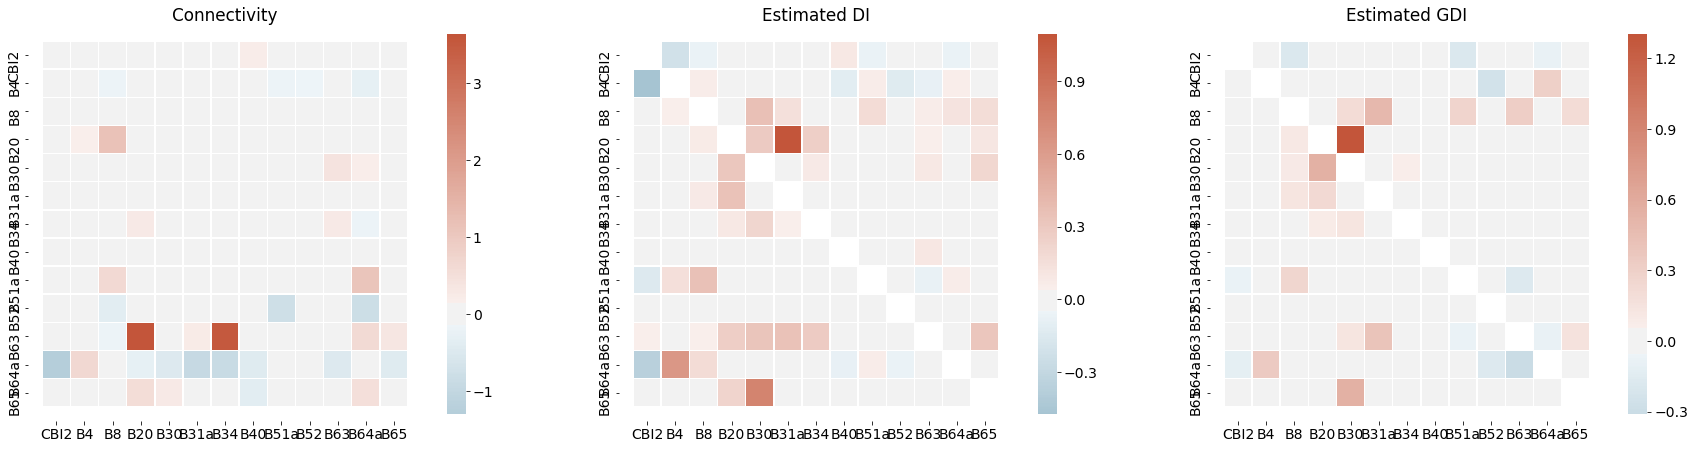

In [16]:
# LOAD TRUE CONNECTIVITY
true_conn = sio.loadmat('cpg.mat')['C']

# FIGURE
f, ax = plt.subplots(figsize=(30, 14))

# COLORMAP
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# TRUE CONNECTIVITY
plt.subplot(131)
sns.heatmap(true_conn, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.yticks(np.arange(binned_spikes.shape[1])+0.5,neuron_names);
plt.xticks(np.arange(binned_spikes.shape[1])+0.5,neuron_names);
plt.xlim((-0.5, 13.5))
plt.ylim((13.5,-0.5))
plt.title('Connectivity')

# DI
plt.subplot(132)
sns.heatmap(DI_est_norm_signed, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.yticks(np.arange(binned_spikes.shape[1])+0.5,neuron_names);
plt.xticks(np.arange(binned_spikes.shape[1])+0.5,neuron_names);
plt.xlim((-0.5, 13.5))
plt.ylim((13.5,-0.5))
plt.title('Estimated DI')

# GDI
plt.subplot(133)
sns.heatmap(GDI_est_norm_signed, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.yticks(np.arange(binned_spikes.shape[1])+0.5,neuron_names);
plt.xticks(np.arange(binned_spikes.shape[1])+0.5,neuron_names);
plt.xlim((-0.5, 13.5))
plt.ylim((13.5,-0.5))
plt.title('Estimated GDI');